In [1]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 5.5 MB/s eta 0:00:00


In [2]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation

Frozen Lake es un entorno simple compuesto por casillas, donde el agente debe moverse desde una casilla inicial hasta una meta.

Las casillas pueden ser un lago congelado seguro ✅ o un agujero ❌ que te deja atrapado por siempre.

El agente, tiene 4 acciones posibles: ir ◀️IZQUIERDA, 🔽ABAJO, ▶️DERECHA o 🔼ARRIBA.

El agente debe aprender a evitar los agujeros para poder alcanzar la meta en el menor número de acciones posible.

Por defecto, el entorno siempre tiene la misma configuración. En el código del entorno, cada casilla está representada por una letra de la siguiente manera:

In [ ]:
# S F F F       (S: inicio, seguro)
# F H F H       (F: superficie congelada, seguro)
# F F F H       (H: agujero, atrapado por siempre)
# H F F G       (G: meta, a salvo)

De hecho, es muy fácil encontrar varias soluciones correctas: DERECHA → DERECHA → ABAJO → ABAJO → ABAJO → DERECHA es una obvia.

Pero podríamos hacer una secuencia de acciones que rodee un agujero 10 veces antes de llegar a la meta. Esta secuencia es válida, pero no cumple con nuestro requisito final: el agente necesita alcanzar la meta en el menor número de acciones posible.

En este ejemplo, el número mínimo de acciones para completar el juego es 6. Necesitamos recordar este hecho para comprobar si nuestro agente realmente domina Frozen Lake o no.

array([[[180, 200, 230],
        [180, 200, 230],
        [180, 200, 230],
        ...,
        [180, 200, 230],
        [180, 200, 230],
        [180, 200, 230]],

       [[180, 200, 230],
        [204, 230, 255],
        [204, 230, 255],
        ...,
        [204, 230, 255],
        [204, 230, 255],
        [180, 200, 230]],

       [[180, 200, 230],
        [235, 245, 249],
        [204, 230, 255],
        ...,
        [204, 230, 255],
        [204, 230, 255],
        [180, 200, 230]],

       ...,

       [[180, 200, 230],
        [235, 245, 249],
        [235, 245, 249],
        ...,
        [204, 230, 255],
        [235, 245, 249],
        [180, 200, 230]],

       [[180, 200, 230],
        [235, 245, 249],
        [235, 245, 249],
        ...,
        [204, 230, 255],
        [204, 230, 255],
        [180, 200, 230]],

       [[180, 200, 230],
        [180, 200, 230],
        [180, 200, 230],
        ...,
        [180, 200, 230],
        [180, 200, 230],
        [180, 200, 230]]], dtype=uint8)
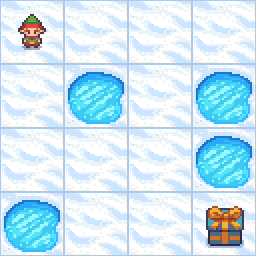

In [4]:
environment = gym.make("FrozenLake-v1", is_slippery=False, render_mode="rgb_array")
environment.reset()
environment.render()

En Frozen Lake, hay 16 casillas, lo que significa que nuestro agente puede encontrarse en 16 posiciones diferentes o estados.

Para cada estado, hay 4 acciones posibles: ir ◀️IZQUIERDA, 🔽ABAJO, ▶️DERECHA, y 🔼ARRIBA.

El agente debe aprender qué acción elegir en cada estado. Para saber qué acción es la mejor en un estado dado, vamos a calcular el Valor-Q de cada acción (Recordar que este valor es función del estado y la acción).

Tenemos 16 estados y 4 acciones, por lo que queremos calcular 16 x 4 = 64 valores Q.

Una forma práctica de representarlo es mediante una tabla, conocida como tabla Q, donde las filas enumeran cada estado s y las columnas enumeran cada acción a.

En esta tabla Q, cada celda contiene el valor $Q(s, a)$, que son las recompensas esperadas de tomar la acción $a$ en el estado $s$

Cuando nuestro agente se encuentra en un estado particular $s$, solo tiene que consultar esta tabla para ver qué acción tiene el valor más alto.

``
S     ◀️LEFT    🔽DOWN    ▶️RIGHT   🔼UP \
0     Q(0,◀️)   Q(0,🔽)   Q(0,▶️)   Q(0,🔼) \
1     Q(1,◀️)   Q(1,🔽)   Q(1,▶️)   Q(1,🔼) \
2     Q(2,◀️)   Q(2,🔽)   Q(2,▶️)   Q(2,🔼) \
. \
14    Q(14,◀️)  Q(14,🔽)  Q(14,▶️)  Q(14,🔼) \
G     Q(15,◀️)  Q(15,🔽)  Q(15,▶️)  Q(15,🔼)
``


In [ ]:
# Creamos la tabla y la inicializamos con ceros
# dimensión (filas x columnas) = (s x a) = 16 x 4

nb_states = environment.observation_space.n  # = 16
nb_actions = environment.action_space.n      # = 4
qtable = np.zeros((nb_states, nb_actions))

print('Q-table =')
print(qtable)

``
◀️ LEFT = 0 \
🔽 DOWN = 1 \
▶️ RIGHT = 2 \
🔼 UP = 3
``

In [ ]:
# Para tomar una acción al azar
print(environment.reset())

accion = environment.action_space.sample()
new_state, reward, done, info, p = environment.step(accion) # Retorna done=True si el agente cae a un agujero o llega a la meta

accion2 = environment.action_space.sample()
new_state, reward, done, info, p = environment.step(accion2) # Retorna done=True si el agente cae a un agujero o llega a la meta

print(accion)
print(f'recompensa:', reward)
print(f'Done:', done)
environment.render()

La recompensa es 0 y solo un estado puede darnos una recompensa positiva en todo el juego. Si queremos ver una recompensa de 1, el agente debe tener la suerte suficiente para encontrar la secuencia correcta de acciones. La tabla Q permanecerá llena de ceros hasta que el agente alcance aleatoriamente la meta.

Sabemos que obtenemos una recompensa de 1 cuando llegamos a la meta G. El valor-Q del estado junto a G (G-1) con la acción relevante para llegar a G se actualiza gracias a la recompensa. Se termina el episodio: el agente ganó y se reinicia el juego. Ahora, la próxima vez que el agente esté en un estado junto a G-1, aumentará el valor-Q del estado (llamémoslo G-2) con la acción relevante para llegar a G-1. La próxima vez que el agente esté en un estado junto a G-2, hará lo mismo. se reinicia y repite, hasta que la actualización alcance el estado inicial S.

Implementar el algoritmo Q-Learning para actualizar los valores-Q de la tabla-Q, recordar la ecuación de actualización:

$$
Q_{new}(s_t,a_t) =  Q(s_t,a_t) + \eta\cdot(r_t + \gamma\cdot\max_a Q(s_{t+1}, a) - Q(s_t,a_t))
$$

In [8]:
import matplotlib.pyplot as plt

def Q_learning(env, n_episodes, eta=0.5, gamma=0.9):

    n_states = env.observation_space.n  # = 16
    n_actions = env.action_space.n      # = 4
    qtable = np.zeros((n_states, n_actions))

    for _ in range(n_episodes):
        #reiniciar el agente

        done = False
        #mientras no se finalice el episodio
        while not done:
            #selecciono una acción a partir del qtable para el estado actual
            #si son todos ceros, selecciono una acción al azar


            #implemento la acción usando step


            #actualizo los valores de qtable


            #actualizo el estado
            state = new_state

    return qtable

In [ ]:
environment = gym.make("FrozenLake-v1", is_slippery=False, render_mode="rgb_array")

Qt = Q_learning(environment, n_episodes=1000, eta=0.5, gamma=0.9)
Qt

A continuación implemente la política que retorne la acción del agente usando la Tabla-Q aprendida

In [11]:
def basic_policy(env, Q_table, state):
    """Política del agente"""
    if np.max(Q_table[state]) > 0:
        return np.argmax(Q_table[state])
    else:
        return env.action_space.sample()

In [10]:
# Funciones para animación
def animate(num, patch, frames):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    plt.close()
    anim = FuncAnimation(
        fig, animate, fargs=(patch, frames),
        frames=len(frames), repeat=repeat, interval=interval)
    return anim

def show_one_episode(policy, Q_table):
    sequence = []
    frames = []
    env = gym.make("FrozenLake-v1", is_slippery=False, render_mode="rgb_array")
    state, info = env.reset()
    frames.append(env.render())
    done = False
    while not done:
        action = policy(env, Q_table, state)
        sequence.append(action)
        new_state, reward, done, info, p = env.step(action)
        frames.append(env.render())
        state = new_state
    print(frames[0].shape)
    return plot_animation(frames)

In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML

anim = show_one_episode(policy=basic_policy, Q_table=Qt)
rc('animation', html='jshtml')
anim

Hay algo a tener en cuenta con el enfoque anterior: el agente siempre elige la acción con el valor más alto. Entonces, cada vez que un par estado-acción comienza a tener un valor distinto de cero, el agente siempre lo elegirá. Las otras acciones nunca se tomarán, lo que significa que nunca actualizaremos su valor ¿qué pasa si una de estas acciones es mejor que la que el agente siempre elige? ¿No deberíamos animar al agente a probar cosas nuevas de vez en cuando y ver si puede mejorar?

Entonces, queremos permitir que nuestro agente:

1. Tome la acción con el valor más alto (explotación).
2. Elija una acción al azar para intentar encontrar incluso mejores acciones (exploración).

Es importante encontrar un equilibrio entre estos dos comportamientos: si el agente se enfoca solo en la explotación, no puede probar nuevas soluciones y, por lo tanto, deja de aprender. Por otro lado, si el agente solo toma acciones al azar, el entrenamiento es inútil ya que no utiliza la tabla Q.

Entonces, queremos cambiar este parámetro con el tiempo: al principio del entrenamiento, queremos explorar el entorno tanto como sea posible. Pero la exploración se vuelve menos interesante a medida que el agente ya conoce todos los pares estado-acción posibles. Este parámetro representa la cantidad de aleatoriedad en la selección de acciones.

Esta técnica se conoce comúnmente como el algoritmo epsilon-greedy, donde epsilon es nuestro parámetro. Es un método simple pero extremadamente eficiente para encontrar un buen equilibrio. Cada vez que el agente tiene que tomar una acción, tiene una probabilidad ε de elegir una al azar, y una probabilidad 1-ε de elegir la que tiene el valor más alto. Podemos disminuir el valor de epsilon al final de cada episodio en una cantidad fija (decaimiento lineal).

In [ ]:
def epsilon_greedy(env, n_episodes, eta=0.5, gamma=0.9, epsilon=1, decay=0.001):

    n_states = env.observation_space.n  # = 16
    n_actions = env.action_space.n      # = 4
    qtable = np.zeros((n_states, n_actions))

    for _ in range(n_episodes):
        #reiniciar el agente
        state, _ = env.reset()
        done = False
        #mientras no se finalice el episodio
        while not done:
            # genero un número aleatorio entre 0 y 1


            # si el número es menor a epsilon
            # tomo una acción aleatorio
            # sino uso la qtable



            #implemento la acción usando step


            #actualizo los valores de qtable


            #actualizo el estado
            state = new_state

        #actualizo epsilon restando el decaimiento


    return qtable

In [ ]:
env2 = gym.make("FrozenLake-v1", is_slippery=False, render_mode="rgb_array")

Qt = epsilon_greedy(env2, n_episodes=10000, eta=0.2, gamma=0.9)
Qt

In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML

anim = show_one_episode(policy=basic_policy, Q_table=Qt)
rc('animation', html='jshtml')
anim